### Imports

In [1]:
from ce.cp_and_calibration import perform_platt_scaling
import numpy as np
import pandas as pd
from tqdm import tqdm
import json 
from scipy.sparse import csr_matrix
from scipy.sparse import load_npz
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

### Data generation (poor calibration)

In [2]:
n_points = 75
eligible_tasks=[0]

In [3]:
inactive_preds = np.clip(
    np.linspace(0.001,1,n_points)**4,
    0,1
)

In [4]:
active_preds = np.clip(
    1-np.power(np.linspace(0.01,1,n_points)
                       , 2)+0.00001,
    0,1
)

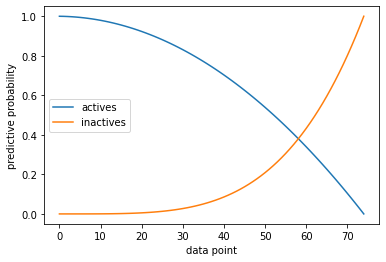

In [5]:
_ = plt.plot(active_preds)
_ = plt.plot(inactive_preds)
_ = plt.legend(['actives','inactives'])
_ = plt.ylabel('predictive probability')
_ = plt.xlabel('data point')

In [6]:
labels_va = np.hstack([
    np.tile([-1],reps=n_points)
    ,np.tile([1],reps=n_points)
          ])
labels_va.shape

(150,)

In [7]:
preds_va = np.hstack([inactive_preds,active_preds])
preds_va.shape

(150,)

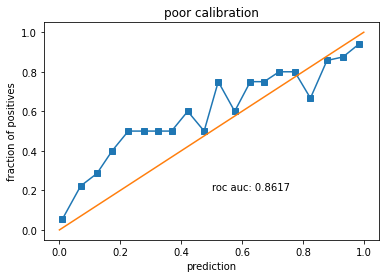

In [8]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    np.where(labels_va==-1,0,1)
    ,preds_va
    ,n_bins=20
)
plt.plot(
          mean_predicted_value
         , fraction_of_positives
         , "s-",
             )

roc_auc = roc_auc_score(labels_va.flatten(),preds_va)
plt.text(.5,.2,'roc auc: {}'.format(round(roc_auc,4)))

plt.ylabel('fraction of positives')
plt.xlabel('prediction')
_ = plt.title('poor calibration')
_ = plt.plot([0,1],[0,1])

In [9]:
csr_matrix(labels_va).T

<150x1 sparse matrix of type '<class 'numpy.int64'>'
	with 150 stored elements in Compressed Sparse Column format>

In [10]:
csr_matrix(preds_va).T

<150x1 sparse matrix of type '<class 'numpy.float64'>'
	with 150 stored elements in Compressed Sparse Column format>

In [11]:
df_platt = perform_platt_scaling(
                        csr_matrix(labels_va).T
                      , csr_matrix(preds_va).T
                      , eligible_tasks
)
df_platt

100%|██████████| 1/1 [00:00<00:00, 140.20it/s]


,coeffs,intercepts,idx
0,0.56674,0.457635,0


### Calibrate the predictive probabilities

In [12]:
arr = preds_va
logits = np.log(arr/(1-arr))
preds_platt = 1/(1+np.exp(-(logits*df_platt['coeffs'][0]+df_platt['intercepts'][0])))

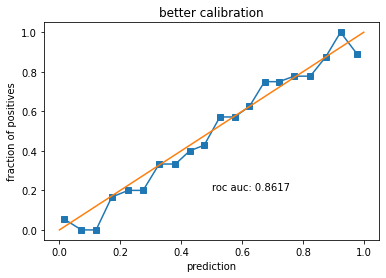

In [13]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    np.where(labels_va==-1,0,1)
    ,preds_platt
    ,n_bins=20
)
plt.plot(
          mean_predicted_value
         , fraction_of_positives
         , "s-",
             )

roc_auc = roc_auc_score(labels_va.flatten(),preds_va)
plt.text(.5,.2,'roc auc: {}'.format(round(roc_auc,4)))

plt.ylabel('fraction of positives')
plt.xlabel('prediction')
_ = plt.title('better calibration')
_ = plt.plot([0,1],[0,1])

In [14]:
assert roc_auc_score(labels_va.flatten(),preds_platt) == roc_auc_score(labels_va.flatten(),preds_va)